<a href="https://colab.research.google.com/github/BrockDSL/ARCH_Data_Explore/blob/main/Muni_Data_Explore_and_Export.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![dsl_logo.png](https://raw.githubusercontent.com/BrockDSL/Analyzing_Web_Archives/main/dsl_logo.png)

# COVID 19 Archive by Niagara Municipality

The following notebook provides an investigation into a subset of the [COVID-19 in Niagara Data set](https://archive-it.org/collections/13781). We'll be loading up a collection of web pages provided by different municipalities in the niagara region, hosted at the following domains:

- niagararegion.ca
- notl.com
- stcatharines.ca
- niagarafalls.ca
- lincoln.ca
- forterie.ca
- grimsby.ca
- portcolborne.ca
- thorold.ca
- welland.ca
- westlincoln.ca
- wainfleet.ca
- pelham.ca


## How this notebook works

This webpage is a Google Colab notebook and is comprised of different *cells*. Some are code cells that run Python snippets. To works through these cells simply click on the triangle _run_ button in each cell.


In [2]:
#Loading Libraries and Settign options
# Click the run button to the left to start up this notebook

import pandas as pd
import gdown
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from google.colab import files

pd.set_option('display.max_colwidth', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

print("Libraries loaded. Ready to proceed.")


Libraries loaded. Ready to proceed.


Need to patch to newest version of gdown to fix error about bad downloads

In [3]:
!pip install --upgrade --no-cache-dir gdown

!pip show gdown

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=e2e35436da4ece157b6f3fa0ca8470f9c468db2df5f90feca2d71225c631605e
  Stored in directory: /tmp/pip-ephem-wheel-cache-y21ye8cz/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


Name: gdown
Version: 4.4.0
Summary: Google Drive direct download of big files.
Home-page: http://github.com/wkentaro/gdown
Author: Kentaro Wada
Author-email: www.kentaro.wada@gmail.com
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: six, tqdm, filelock, requests, beautifulsoup4
Required-by: 


## Loading the data

We've processed the data by creating a *CSV* file of the webpages from the domains above that are found in the archive. That way we can some text analysis on it directly. Here we read it in and show some basic information about it.

In [3]:
#File is so big we need to download it as a zip file, then uncompress it

gdown.download("https://drive.google.com/u/0/uc?id=1oKNphdZkuNfeh-beuTkcIBo_EFLWO9zX&export=download","municipal_data.csv.gz",quiet=False)
!gunzip municipal_data.csv.gz
archive_data = pd.read_csv("municipal_data.csv")
#get rid of some uneeded cols
del(archive_data['Unnamed: 0'])
del(archive_data['index'])
del(archive_data['mime_type_web_server'])
del(archive_data['mime_type_tika'])
del(archive_data['language'])
archive_data['crawl_date']= pd.to_datetime(archive_data['crawl_date'],format='%Y-%m-%d')
print("Data Loaded")

Downloading...
From: https://drive.google.com/u/0/uc?id=1oKNphdZkuNfeh-beuTkcIBo_EFLWO9zX&export=download
To: /content/municipal_data.csv.gz
100%|██████████| 51.3M/51.3M [00:00<00:00, 113MB/s]


Data Loaded


## Random entry for flavour

Most columns are self explantory. the _v__ columns are the calulated [VADER](https://github.com/cjhutto/vaderSentiment) scores for that web page. _Length_ is how many characters are on that webpage


In [ ]:
archive_data.sample(1)

,crawl_date,domain,url,content,length,v_pos,v_neg,v_neu,v_comp
25403,2020-10-16,niagararegion.ca,https://www.niagararegion.ca/waste/default.aspx,"Garbage, Recycling and Organics - Niagara Region, Ontario Get updates on COVID-19 and learn about our closures and service disruptions. Garbage, Recycling and Organics Oct. 15: Waste collection wasn't completed in Lincoln. Incomplete areas will be a priority the next day. Changes are Coming Oct. 19 Changes coming to curbside collection with the new collection contracts Waste collection changes Collection Day Details Find the day your garbage, recycling and organics is picked up Large Item Collection Book online or call at least two working days in advance of your regular collection day Pick-up / Replace Recycling Containers Free for new homeowners or replace damaged containers Report Illegal Dumping Report illegally dumped material online or call us at 1-800-594-5542 Household Chemical Drop-off Residents can drop off household hazardous waste at permanent depots year round Donate / Drop-off Reusable Items Locations and lists of items that can be dropped off / donated Garbage Tag Locations Prices and locations to pick-up tags for extra item disposal Exemption Applications Diaper, daycare, medical, group home and charity collection exemption forms Every-other-Week Garbage Collection Every-other-week garbage collection starts Oct. 19 for Fort Erie, Niagara-on-the-Lake, Pelham, St. Catharines, Thorold, Wainfleet and West Lincoln. Every-other-week garbage collection starts Oct. 26 for Grimsby, Lincoln, Niagara Falls, Welland and Port Colborne. There will be no garbage collection the week of Oct. 19. Your Blue Box, Grey Box and Green Bin will continue to be collected every week. There's no limit to the amount of recycling and organics that can be placed at the curb. See the temporary waste changes in place due to the pandemic. Collection Schedule App Never forget your collection day again. Download the Niagara Region Waste app to get notifications to your phone for collection day reminders and service disruptions. iOS / Apple App Store Android / Google Play Store Where Does it Go? Mattress TV Computer Paint Carpet Drywall Batteries Glass Search all materials Waste Info-line Call the Waste Info-line Monday to Friday 8 a.m. - 5 p.m. 905-356-4141 Toll-free: 1-800-594-5542 Rethink Your Waste at Your Workplace Join an ever growing community of businesses who are committed to reducing their environmental footprint. Take the pledge Page Feedback Did you find what you were looking for today? Yes No Garbage, Recycling Collection Items Collected Item Disposal Containers, Bags, Carts Landfills Presentations Contact Home Menu Buses, Roads, Maps and Trails Business and Development Careers, Job Opportunities Child Care, Assistance Garbage, Recycling and Organics Government and Council Health and Safety Property Taxes Provincial Courts, By-laws Seniors Services, Long-term Care Social Assistance Water and Wastewater Search A - Z Services Contact Us Job Opportunities Disclaimer and Privacy Accessibility News and Notices © Niagara Region - 1815 Sir Isaac Brock Way, Thorold, ON, L2V 4T7 - Phone: 905-980-6000, Toll-free: 1-800-263-7215",3065,0.07,0.097,0.833,-0.9231


## General information about the dataset

In [ ]:
print("Total Number of total records in dataset: ",len(archive_data))

Total Number of total records in dataset:  61160


Domains information captured in dataset:

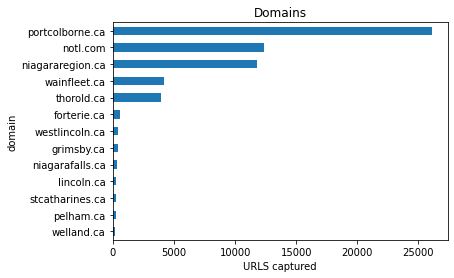

In [ ]:
ax = archive_data.groupby("domain")["url"].count().sort_values().plot(kind='barh')
ax.set_title("Domains")
ax.set_label("Number of captures")
ax.set_xlabel("URLS captured")
plt.show()

## Specific City


In [4]:
#@title Specific City Data
#@markdown Pick a city to see data just from it. URLs are sorted from most frequent to least
Selected = "niagararegion.ca" #@param ["niagararegion.ca","notl.com", "stcatharines.ca", "niagarafalls.ca","lincoln.ca","forterie.ca","grimsby.ca","portcolborne.ca","thorold.ca","welland.ca","westlincoln.ca","wainfleet.ca", "pelham.ca"] {allow-input: true}
#@markdown How many URLs to show
Count = 10  #@param {type: "slider", min: 1, max: 50}

#@markdown Be sure to hit the *run* button to confirm your selection

city_data = archive_data[archive_data.domain == Selected]
city_data.groupby("url").count().sort_values(by="crawl_date",ascending=False)[0:Count]

,crawl_date,domain,content,length,v_pos,v_neg,v_neu,v_comp
url,,,,,,,,
https://www.niagararegion.ca/health/covid-19/default.aspx/,179,179,179,179,179,179,179,179
https://www.niagararegion.ca/health/covid-19/default.aspx,93,93,93,93,93,93,93,93
https://www.niagararegion.ca/service-disruptions/default.aspx,92,92,92,92,92,92,92,92
https://www.niagararegion.ca/health/covid-19/protect-yourself.aspx,92,92,92,92,92,92,92,92
https://www.niagararegion.ca/government/municipalities/link-fort-erie,91,91,91,91,91,91,91,91
https://www.niagararegion.ca/default.aspx,91,91,91,91,91,91,91,91
https://www.niagararegion.ca/exploring/default.aspx?home_task=1,91,91,91,91,91,91,91,91
https://www.niagararegion.ca/living/childcare/default.aspx?topnav=1,91,91,91,91,91,91,91,91
https://www.niagararegion.ca/living/childcare/default.aspx?home_task=1,91,91,91,91,91,91,91,91


## Specific URL Data

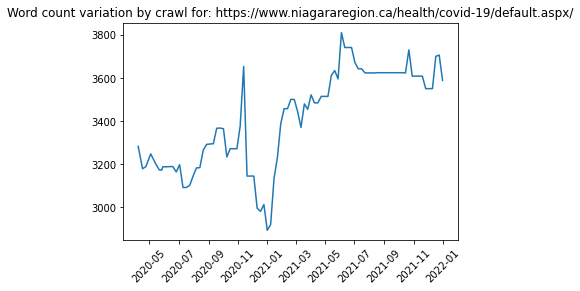

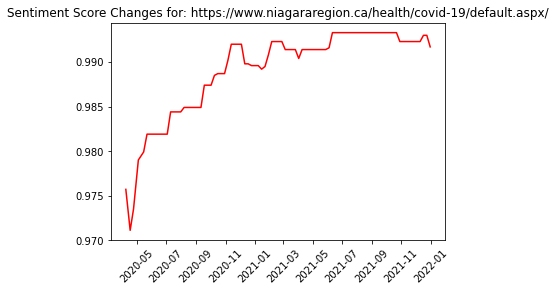

,crawl_date,length,score,link
0,20200408,3283,0.9757,https://web.archive.org/web/20200408/https://www.niagararegion.ca/health/covid-19/default.aspx/
1,20200417,3179,0.9711,https://web.archive.org/web/20200417/https://www.niagararegion.ca/health/covid-19/default.aspx/
2,20200424,3189,0.9735,https://web.archive.org/web/20200424/https://www.niagararegion.ca/health/covid-19/default.aspx/
3,20200504,3248,0.9790,https://web.archive.org/web/20200504/https://www.niagararegion.ca/health/covid-19/default.aspx/
4,20200515,3199,0.9799,https://web.archive.org/web/20200515/https://www.niagararegion.ca/health/covid-19/default.aspx/
5,20200522,3173,0.9819,https://web.archive.org/web/20200522/https://www.niagararegion.ca/health/covid-19/default.aspx/
6,20200529,3188,0.9819,https://web.archive.org/web/20200529/https://www.niagararegion.ca/health/covid-19/default.aspx/
7,20200626,3164,0.9819,https://web.archive.org/web/20200626/https://www.niagararegion.ca/health/covid-19/default.aspx/
8,20200703,3198,0.9819,https://web.archive.org/web/20200703/https://www.niagararegion.ca/health/covid-19/default.aspx/
9,20200710,3092,0.9844,https://web.archive.org/web/20200710/https://www.niagararegion.ca/health/covid-19/default.aspx/


In [5]:
#@title Specific URL Data
url = "https://www.niagararegion.ca/health/covid-19/default.aspx/" #@param {type:"string"}

#@markdown Be sure to hit the *run* button to confirm your selection

url_data = archive_data[archive_data.url == url]
url_data = url_data.sort_values(by="crawl_date")

#line plot of crawl date with length and v_comp

url_data = archive_data[archive_data.url == url]
url_data = url_data.sort_values(by="crawl_date")

plt.plot(url_data['crawl_date'],url_data['length'])
plt.xticks(rotation=45)
plt.title("Word count variation by crawl for: " + url)
plt.show()


plt.plot(url_data['crawl_date'],url_data['v_comp'],color="red")
plt.xticks(rotation=45)
plt.title("Sentiment Score Changes for: " + url)
plt.show()



unique_days = url_data.groupby("length").first().sort_values(by='crawl_date')
#url_map = pd.DataFrame(columns=["crawl_date","length","score","link"])
url_map = pd.DataFrame(columns=["crawl_date","length","score","link"])
for row in unique_days.itertuples():
    date = row.crawl_date
    date =  str(date).split(' ')[0].replace('-','')
    length = len(row.content)
    score = row.v_comp
    line = []
    line.append(date)
    line.append(length)
    line.append(score)
    line.append(str("https://web.archive.org/web/" + date + "/" + url))
    line = pd.Series(line, index = url_map.columns)
    #print(line,"\n")
    url_map = url_map.append(line, ignore_index=True)

url_map

## Download city Dataset

In [ ]:
city_data.to_csv(Selected+".city.data.csv", index=False)
files.download(Selected+".city.data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Download URL Specific Dataset

In [ ]:
url_label = str(url).split("//")[1]
url_label = url_label.strip("/")
url_label = url_label.replace("/",".")
url_label = url_label+".url.data.csv"
url_map.to_csv(url_label,index=False)
files.download(url_label)